In [61]:
import os
import numpy as np
import albumentations as T
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import torchvision
from albumentations.core.transforms_interface import ImageOnlyTransform
import math
# from src.utils import visualize
from utils import visualize
class ImagesFromFolder(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, preprocess_input=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.preprocess_input = get_preprocessing(preprocess_input)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])

         # read data
        image = np.array(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
        # image = image.transpose(2, 0, 1).astype('float32')
        mask = np.array(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE))

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        # if self.preprocess_input is not None:
        #     preprocessing = self.preprocess_input(image=image, mask=mask)
        #     image, mask = preprocessing['image'], preprocessing['mask']
        # else:
        #     image = (image / 255.)
        return image, mask#np.expand_dims(image, axis=0) / 255., np.expand_dims(mask, axis=0)


def loaders(train_imgdir,
            train_maskdir,
            val_imgdir,
            val_maskdir,
            batch_size,
            num_workers=4,
            pin_memory=True,
            preprocess_input=None
            ):

    train_transforms = T.Compose(
        [
            T.Rotate(limit=(-20, 20), p=0.5),
            T.HorizontalFlip(p=0.5),
            ContrastNormalization(always_apply=True, th=0.5),
            T.Affine(scale=(0.9, 1.1), p=1.0),
            # T.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=1.0),
            T.CLAHE(clip_limit=2.0, tile_grid_size=(2, 2), p=0.5),
        ]
    )

    train_ds = ImagesFromFolder(image_dir=train_imgdir,
                                mask_dir=train_maskdir,
                                transform=train_transforms,
                                preprocess_input=preprocess_input
                                )

    val_ds = ImagesFromFolder(image_dir=val_imgdir,
                              mask_dir=val_maskdir,
                              transform=None,
                              preprocess_input=preprocess_input
                              )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )
    return train_loader, val_loader


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = [
        T.Lambda(image=preprocessing_fn),
    ]
    return T.Compose(_transform)

class ContrastNormalization(ImageOnlyTransform):
    def __init__(self, always_apply: bool = False, p: float = 0.5, th=0.5):
        super().__init__(always_apply, p)
        self.th = th
    def apply(self, img, **params):
        return contrast_normalization(img, th=self.th)

def contrast_normalization(img, th):
    c = np.random.uniform(1,3)
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        gray = img
    contrast = michelson(gray)
    
    gray = gray / 255.
    proc = np.zeros(gray.shape)
    for i in range(0, gray.shape[0]):
        for j in range(0, gray.shape[1]):
            proc[i,j] = 255 * math.exp(1*c*gray[i,j]) / math.exp(c)
    if contrast < th:
        out = proc
        print(f'{contrast:0.4f}')
    else:
        out = gray * 255
    return out.astype(np.uint8)

def michelson(gray):
    hist, _ = np.histogram(gray.ravel(),256,[0,256])
    hist = np.trim_zeros(hist)
    mid = math.ceil(len(hist)/2)
    hminp = hist[:mid]
    hmaxp = hist[mid:]
    lmax = np.mean(hmaxp)
    lmin = np.mean(hminp)
    contrast = abs((lmax - lmin) / (lmax + lmin))
    #print(f'{contrast:0.4f}')
    return float(contrast)


0.7311
0.6069


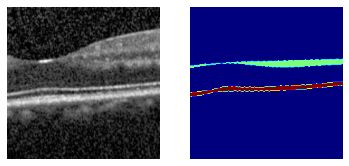

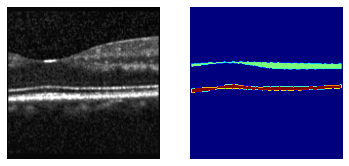

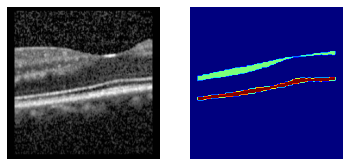

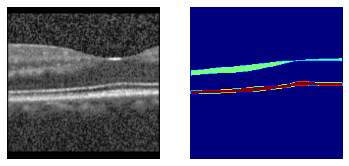

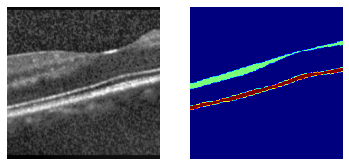

In [103]:
train_transforms = T.Compose(
    [
        T.Rotate(limit=(-20, 10), p=1.0),
        T.HorizontalFlip(p=0.5),
        T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, p=1.0),
        T.Affine(scale=(0.9, 1.1), p=1.0),
        ContrastNormalization(always_apply=True, th=0.8, p=1.0),
        T.CLAHE(clip_limit=1.0, tile_grid_size=(3, 3), p=1.0),
        
    ]
)
train_ds = ImagesFromFolder(image_dir='../dataset/224_2C/train_images',
                            mask_dir='../dataset/224_2C/train_masks',
                            transform=train_transforms,
                            )

imgs=[]
msks=[]
randint = np.random.randint(low=0, high=len(train_ds))
n = 5
for i in range(n):
    image, mask = train_ds[randint]
    figure, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(np.array(image), cmap='gray')
    ax[1].imshow(np.array(mask), cmap='jet')
    ax[0].axis('off')
    ax[1].axis('off')
# visualize(len(imgs), np.array(imgs), np.array(msks), pr_mask=None, path_save='', metric_dict=None)